# Group 32 - Neural Computation Coursework Report

**Reconstruction Images Can Be Found Here: https://www.dropbox.com/sh/po8oqijfiyovlei/AADfzFqMhpNOXBDU8RQYlmrTa?dl=0**

## Introduction

Long acquisition times in fully-sampled MRI lead to low patient throughput, problems with patient comfort and compliance, artefacts from patient motion, and high examination costs. Reducing acquisition time using under-sampling helps to mitigate these issues, however, this comes at the const of reconstructed image quality. This machine learning task aims to improve the viability of the more efficient under-sampling strategy by designing a system that maximises the quality of under-sampled reconstructions. High-quality reconstructions, in this context, would be images that closely align with the ground truth, the fully-sampled image.

The MRI dataset provided contained raw k-space data from 100 3D volumes, each having approximately 30-40 2D slices. The data was split into training and testing sets with ratio 7:3 respectively. The training set contained only fully sampled k-space data from which ground truth and under-sampled data could be derived. The test set contained 4-fold and 8-fold undersampled k-space data as well as the 4-fold and 8-fold masks that generated this data.


## Design

The use of deep learning for undersampled biomedical image reconstruction is still a very new field and there is some uncertainty as to what type of neural network can best complete the task. As a result, only a minority of relevant papers available to us at the research stage were directly related to under-sampled image reconstruction. The rest covered biomedical imaging more broadly.

After considering various models, we settled on a convolutional neural network based on the U-Net architecture. Based on our research, U-Nets are regarded as one of the most effective and usable types of convolutional neural networks for biomedical imaging tasks. This was especially true where the task was reconstructing under-sampled images<sub>3</sub>.

The major attraction towards U-Nets for such tasks is their apparent lack of overfitting risk. The performance of the U-Net models continues to increase with increasing model capacity, and even the largest model with over 200 million parameters is unable to overfit the training data <sub>1</sub>.

A U-Net has a symmetrical architecture, as shown in Figure 1,  that is made up of three sections: the contraction, the bottleneck and the expansion. The contraction section is made of blocks which use convolution layers followed by a ReLU (rectified linear unit) layer, and a max pooling layer. This section produces feature maps which are then taken and used to reconstruct an image in the expansion section. The expansion layer works in the same way as the contraction path, only it aims to add localization to the contextual information from the contracting path. An illustration of the downsampling and upsampling path can be found in the diagram below.

Unlike many models, U-Nets can be used for inputs with different shapes, as they do not have dense layers. This is a huge advantage for datasets where the shape of data is unknown. This relates well to the FastMRI dataset, as each file has a varying number of slices to the last, giving us one unknown - dimension size.

![](1-unet-arch.png)
Fig 1. U-Net Architecture Diagram, src: http://www.deeplearning.net/tutorial/_images/unet.jpg


The other types of Neural Networks we looked at:
- Convolutional Recurrent Neural Network: <br>
RNNs are very good at learning sequential events, especially those that require memory of past events. This makes them particularly useful for text-based tasks. However, convolutional RNNs were proposed for reconstructed cardiac MR images from undersampled k-space data. This was because their bidirectionality allows the model to learn Spatio-temporal dependencies with a very small number of parameters. <sub>6</sub> <br>
While a CRNN may have been a viable choice for this project, the only real advantage over a CNN is its bidirectional properties. Due to its bidirectional nature (learning from past and future slices), and short term memory, the noise of some slices could be detrimental to the outcome of the next slice, resulting in very skewed images. 
- Generative Adversarial Networks:  <br> A GAN is an adversarial model seemed promising for this task from our research but it was not used as it does not preserve the spatial structure of an image like a CNN would.<sub>8</sub> 

CNN architectures we looked at:<br>
- DenseNet: <br> An extension of the ResNet architecture which connects each layer with every other layer in a feed-forward manner. It has been shown to strengthen feature propagation and encourage the reuse of features whilst also reducing the number of parameters<sub>5</sub>. We used U-Net over this as it is made to reconstruct images from feature maps and thus well suited to this task.
- FusionNet: <br> An improved version of U-Net with implementation of a residual block consists of 3 convolutional layers and 1 skip layer. Moreover, it trains data with downscaling and upscaling, therefore each of the residual block has its input and output connected with a convolutional layer to not only making the input being consistent but also achieve perfect symmetry. This network is fully residual as the concatenation is replaced with summation after the skip which makes this neural network being highly accurate because it prevents common problem with deep-network such as gradient vanishing. Despite this network is really tempting to reproduce, but it is difficult to be reproduced from the paperwork.<sub>7</sub>
- VGG: <br> This architecture is a fairly straightforward CNN which we deemed unsuitable for this task as it does not expand the features to produce an image and we thought it best to use a tested model over extending this one. It is more suited for classification tasks.


Loss Functions Considered: <br>
- L1 Loss: <br> The first, and simplest, loss function that we used. Allowed for testing of other parts of the model but is not as good as other loss functions at reducing error.
- MSE Loss (L2 Loss):  <br> A better loss function than L1 which reduced loss to better levels than L1 in fewer epochs. However, this function doesn’t handle large errors well and this can be seen in the spikes in figure 11. Despite this, the function manages to recover and decreases loss to a considerable degree.
- SSIM Loss: <br> This function finds the loss in structural similarity (SSIM) by 1 - SSIM where the value of SSIM is computed by comparing structural similarity between the ground truth and the reconstructed image. This method aims to maximise the SSIM values of our reconstructions.


We chose to experiment with the following hyperparameters:
- Epoch: <br> A higher number of epochs resulted in a lower error in the model but took more time for the model to train. Diminishing returns can be seen when the number of epochs was over 40. This is understandable as epochs are the number of pass-throughs done over the whole dataset and a lower number would mean the network was exposed to less data.
- Learning Rate: <br> A higher learning rate resulted in our model achieving lower losses after a smaller number of epochs, however, a learning rate too high in comparison to the gradient leads to drastic changes which lead to divergent behaviours. Too low a learning rate and the network will take a long time to train. As such we had to balance this hyperparameter such that it was adjusting weights to a reasonable degree without risk of it missing the minima or bouncing back and forth between the minima without converging.
- Dropout Probability: <br> The chosen value for dropout probability balanced overfitting without removing too many inputs.
- Step Size: <br> It is used for triggering StepLR() in optimiser for decaying its learning rate after each of the step size specified epoch.
- Learning Rate Gamma: <br>  It is used as a value of decay in optimiser after specific epoch reaches as stated in step_size under the class StepLR(). 
- Channel Number: <br> Increasing channel number should positively impact SSIM<sub>3</sub>, however, for our setup, this was not the case. A higher number of channels resulted in a lower L1 loss but lead to longer training times and worse SSIM accuracy scores. This is due to the fact the training cut off before the model was able to reach its optimal performance, and so the feature space was larger but also less well learnt. As a consequence, we had to ensure we ran the final model at a channel number that allowed for our model to train in a reasonable time, whilst producing good scores. 


# Implementation

We began by implementing a U-Net from scratch, but quickly ran into problems that were ambiguous. After some research, we found a pre-existing model provided in the Facebook research fast MRI project<sub>3<sub>.

By opting to use a pre-existing model, we could ensure that our basic model configuration was correct. This meant that we could exclude the model class as a potential problem causing area when we ran into issues with the wider program.

The notebook below is set to run for 8f acceleration. To change it to work for 4f, the acc and cent_fract variables need to be changed to the values stated.

### Define Environment and Hyper Parameters

In [1]:
import os
import time
import h5py
import torch
import numpy as np
from functions import transforms as T
from functions.subsample import MaskFunc
from torch import nn
from torch.nn import Conv2d, Sequential, InstanceNorm2d, ReLU, Dropout2d, Module, ModuleList, functional as F
from torch.utils.data import DataLoader
from torch.optim import RMSprop
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from scipy.io import loadmat
from skimage.measure import compare_ssim 
from matplotlib import pyplot as plt

In [2]:
# labs
data_path_train = '/data/local/NC2019MRI/train'
data_path_test = '/data/local/NC2019MRI/test'

# CHANGE OUTPUT DIRECTORY - output directory for test images
out_dir = "/tmp/nc-32/"

# 0.2 = split training dataset into 20% validation data, 80% training data
train_val_split = 0.2

# for mask 4AF - acc = 4, cen = 0.08
# for mask 8AF - acc = 8, cen = 0.04
acc = 8
cen_fract = 0.04

seed = True # random masks for each slice 
num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data

# Model parameters
in_chans = 1
out_chans = 1
chans = 8
# This needs to be (1,1) for the model to run...why...
kernel_size=(1, 1)

# Hyperparameters
epochs = 30
dropout_prob = 0.01
learning_rate = 0.001
weight_decay = 0.0
step_size = 12
lr_gamma = 0.1 # change in learning rate
num_pool_layers = 4

# Check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

### Data Visualisation

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

### Data Loading and Processing

In [4]:
def load_data_path(train_data_path):
#  eventually make this random subsets by shuffling data for
    """ Go through training data path, list all file names, the file paths and the slices of subjects. 
    Split into training and validation set depending on value of train_val_split
    """
    train_files = []
    val_files = []
    
    files = len(os.listdir(train_data_path))
    train_files_num = (1 - train_val_split) * files

    i = 0    
    for fname in sorted(os.listdir(train_data_path)):
        subject_data_path = os.path.join(train_data_path, fname)
        if not os.path.isfile(subject_data_path): continue 
        
        if i <= train_files_num:
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]        
                # the first 5 slices are mostly noise so it is better to exlude them
                train_files += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
        elif i > train_files_num:
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]        
                # the first 5 slices are mostly noise so it is better to exlude them
                val_files += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
        i += 1
        
    return train_files, val_files

In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed):
    ''' random select a few slices (batch_size) from each volume'''
    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]             
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape
    
    # apply mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: 
        norm = 1e-6
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [6]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

## Model

Unet Class <sub>3</sub><br>
The initial implementation of the neural network had the structure outlined below.

The model carries out down-sampling and up-sampling, resulting in the formation of two deep convolutional networks within the U-Net.


In [7]:
class UnetModel(Module):
    """
    PyTorch implementation of a U-Net model. Credit [Ref 3].
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob, kernel_size):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob
        self.kernel_size = kernel_size

        self.down_sample_layers = ModuleList([ConvBlock(in_chans, chans, drop_prob, kernel_size)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob, kernel_size)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob, kernel_size)

        self.up_sample_layers = ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob, kernel_size)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob, kernel_size)]
        self.conv2 = Sequential(
            Conv2d(ch, ch // 2, kernel_size=1),
            Conv2d(ch // 2, out_chans, kernel_size=1),
            Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

The down-sampling convolutional network is made up of four ConvBlocks, and the up-sampling network is made up of five ConvBlocks, where a ConvBlock is defined as shown in the code block below. Each block is made up of Normalisation, Activation (ReLu), and Dropout Layers.

In [8]:
class ConvBlock(Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """
    
    def __init__(self, in_chans, out_chans, drop_prob, kernel_size):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob
        self.kernel_size = kernel_size

        self.layers = Sequential(
            Conv2d(in_chans, out_chans, kernel_size=self.kernel_size),
            InstanceNorm2d(out_chans),
            ReLU(),
            Dropout2d(drop_prob),
            Conv2d(out_chans, out_chans, kernel_size=self.kernel_size),
            InstanceNorm2d(out_chans),
            ReLU(),
            Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args: input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns: (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

## Main Methods

### Test Validation Split
An imperative part of the task was to monitor for signs of overfitting, by splitting training data into training and validation data. Overfitting occurs when the model is learning the training data too well, causing the training loss to continuously decrease, while the validation loss continuously increases.

The mechanism for splitting the data is rather naive, as it takes the first 80% of images as training data, and the remaining 20% as validation data. A future enhancement to this would be to randomise the selection process, as this could boost model accuracy, due to structural difference in images towards the end of the dataset.

This allows for each epoch to run a 'training epoch' and a 'validation epoch', the definitions for which are shown below.


In [9]:
def training_epoch(epoch, model, data_loader, optimizer):
    model.train()
    avg_loss = 0
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    
    for iter, data_sample in enumerate(data_loader):
        # img ground truth, img undersampled, raw data understampled, masks, norm
        img_gt, img_und, rawdata_und, masks, norm = data_sample
        input = T.complex_abs(img_und)
        # crop to 320 320 before feeding into model
        input = T.center_crop(input, [320, 320])
        input = input[None, ...].to(device, dtype=torch.float)
        
        target = T.complex_abs(img_gt)
        target = T.center_crop(target, [320, 320])
        target = target[None, ...].to(device, dtype=torch.float)
        
        # ouput from model
        output = model(input)
        # get loss from L1
        loss = F.l1_loss(output, target)
        # deal with optimizer and loss changes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        start_iter = time.perf_counter()
        
    return avg_loss, time.perf_counter() - start_epoch
    

We tested the model with a few of different loss functions. We found L2 loss to be the best, however for reasons explained in the Experimentation Conclusion, we opted to use L1 as the loss function for the final run.

Experimentation details can be found in the Experiment section of this report.


In [10]:
def validation_epoch(epoch, model, data_loader, optimizer):
    model.train()
    avg_loss = 0
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    
    for iter, data_sample in enumerate(data_loader):
        # img ground truth, img undersampled, raw data understampled, masks, norm
        img_gt, img_und, rawdata_und, masks, norm = data_sample
        input = T.complex_abs(img_und) # absolute values
        input = T.center_crop(input, [320, 320]) # crop to 320  x 320
        input = input[None, ...].to(device, dtype=torch.float) # 3d to 4d tensor
        
        target = T.complex_abs(img_gt)
        target = T.center_crop(target, [320, 320])
        target = target[None, ...].to(device, dtype=torch.float)

        output = model(input)
        # L1 loss function
        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        start_iter = time.perf_counter()
        
    return avg_loss, time.perf_counter() - start_epoch
    

We tested the model with a variety of different optimizers. We found RMSprop returned the best and most consistent results across epochs.

Experimentation details can be found in the Experiment section of this report.


In [11]:
if __name__ == '__main__':       
    # first load all file names, paths and slices.
    train_data, val_data  = load_data_path(data_path_train) 

    # create data loader for training and validation sets
    train_dataset = MRIDataset(train_data, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 

    val_dataset = MRIDataset(val_data, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    # create model object
    model = UnetModel(in_chans=in_chans, out_chans=out_chans, chans=chans, num_pool_layers=4, drop_prob=dropout_prob, kernel_size=kernel_size).to(device)
    # use RMSprop as optimizer
    optimizer = RMSprop(model.parameters(), learning_rate, weight_decay=weight_decay)

Below, we print out a summary of the entire model. This allows us to view all of the layers, the output shapes they produce, and the number of parameters they take as inputs. 

This is useful for debugging as well as ensuring the structure of the UNet is as desired. It allows us to see how the ConBlocks fit together to create the paths and bottleneck.

In [12]:
# input_size=(channels, H, W)
summary(model, input_size=(1, 320, 320), batch_size=1, device=str(device))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 8, 320, 320]              16
    InstanceNorm2d-2           [1, 8, 320, 320]               0
              ReLU-3           [1, 8, 320, 320]               0
         Dropout2d-4           [1, 8, 320, 320]               0
            Conv2d-5           [1, 8, 320, 320]              72
    InstanceNorm2d-6           [1, 8, 320, 320]               0
              ReLU-7           [1, 8, 320, 320]               0
         Dropout2d-8           [1, 8, 320, 320]               0
         ConvBlock-9           [1, 8, 320, 320]               0
           Conv2d-10          [1, 16, 160, 160]             144
   InstanceNorm2d-11          [1, 16, 160, 160]               0
             ReLU-12          [1, 16, 160, 160]               0
        Dropout2d-13          [1, 16, 160, 160]               0
           Conv2d-14          [1, 16, 1

As epochs progress, we monitor the training and validation loss, storing values into an array. Doing this allows us to plot a graph of the training/validation loss over time. The methods and example output of this can be seen below.

In [13]:
# Epochs
scheduler = StepLR(optimizer, step_size, lr_gamma)
current_epoch = 0
# record loss overtime for plotting
train_loss_ot = []
val_loss_ot = []

print("Training on " + str(len(train_data)))
print("Validating on " + str(len(val_data)))
    
# run model epochs
for epoch in range(current_epoch, epochs):
    scheduler.step(epoch)
    print("Epoch: " + str(epoch+1) + "/" + str(epochs))
    train_loss, train_time = training_epoch(epoch, model, train_loader, optimizer)
    val_loss, val_time = validation_epoch(epoch, model, val_loader, optimizer)
    train_loss_ot.append(train_loss)
    val_loss_ot.append(val_loss)
    print(" Train Loss: " + str(train_loss) + " | Validation Loss: " + str(val_loss))
    print("Train Time: " + str(train_time) + " | Validation Time: " + str(val_time))

Training on 1714
Validating on 420
Epoch: 1/30


/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Train Loss: 0.08902829676587597 | Validation Loss: 0.08769526493829764
Train Time: 43.18503784100176 | Validation Time: 10.92780087000574
Epoch: 2/30
 Train Loss: 0.08134594564888803 | Validation Loss: 0.08261618428027924
Train Time: 43.53936487899773 | Validation Time: 11.043795606005006
Epoch: 3/30
 Train Loss: 0.08156015363647438 | Validation Loss: 0.08287264616890765
Train Time: 43.81000638599653 | Validation Time: 11.057788054000412
Epoch: 4/30
 Train Loss: 0.08047295509632853 | Validation Loss: 0.07839867432881459
Train Time: 43.84688671999902 | Validation Time: 11.029120551997039
Epoch: 5/30
 Train Loss: 0.078317310171168 | Validation Loss: 0.07558802432858965
Train Time: 43.906293765001465 | Validation Time: 11.095935872006521
Epoch: 6/30
 Train Loss: 0.07573129067755716 | Validation Loss: 0.07864399153909465
Train Time: 43.852954949994455 | Validation Time: 11.089070130001346
Epoch: 7/30
 Train Loss: 0.07472796991223941 | Validation Loss: 0.07544973719236349
Train Time: 43.81

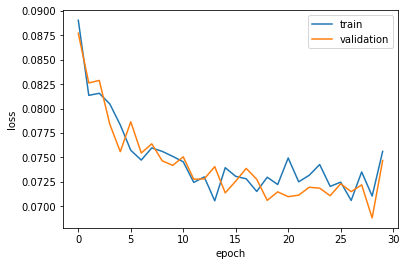

In [14]:
plt.plot(train_loss_ot, label='train')
plt.plot(val_loss_ot, label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss-8f-' + str(epochs) + '.png')
plt.show()

### Test Model (This method is just for testing visualization of the model)
Here weare testing some of the outputs of the model to ensure that we are getting and image output that is better than the undersampled and tending towards the ground truth image.

In [15]:
data_sample = next(iter(train_loader))
# img ground truth, img undersampled, raw data understampled, masks, norm
img_gt, img_und, rawdata_und, masks, norm = data_sample
img_und = T.complex_abs(img_und)
img_und_cropped = T.center_crop(img_und, [320, 320])
img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)

img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 
pred = model(img_und_normalised)

torch.Size([320, 320])
torch.Size([320, 320])
torch.Size([320, 320])


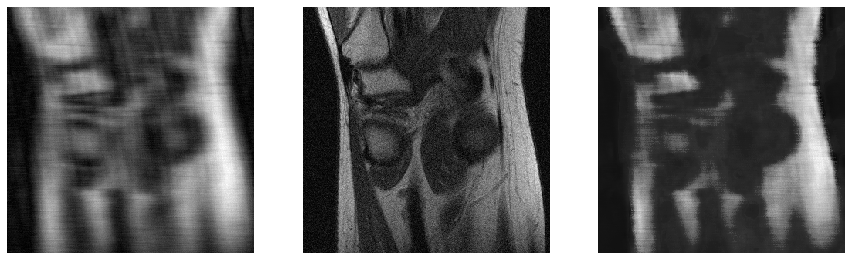

In [16]:
img_gt = T.complex_abs(img_gt)
img_gt_cropped = T.center_crop(img_gt, [320,320])
img_gt_2d = img_gt_cropped[-1,:,:]

# img_und = T.complex_abs(img_und)
img_und_cropped = T.center_crop(img_und, [320,320])
# to 2s
img_und_2d = img_und_cropped[-1,:,:]

# bring to cpu
predc = pred.cpu().detach()
# prediction 4d -> 3d
pred3d = predc[-1,:,:,:]
# prediction 3d -> 2d
pred2d = predc[-1,-1,:,:]

print(img_gt_2d.shape)
print(img_und_2d.shape)
print(pred2d.shape)
all_imgs = torch.stack([img_und_2d,img_gt_2d, pred2d], dim=0)
show_slices(all_imgs, [0,1,2], cmap='gray')

Image order: Under Sampled, Ground Truth, Model Output <br>
    
As you can see, the model output, while not resembling the ground truth that well, is a lot less clearer than the undersampled image.

### Get results from training and validation data

In [17]:
gts = []
preds = []

for iter, data_sample in enumerate(train_loader):
    # img ground truth, img undersampled, raw data understampled, masks, norm
    img_gt, img_und, rawdata_und, masks, norm = data_sample
    img_und = T.complex_abs(img_und)
    img_und_cropped = T.center_crop(img_und, [320, 320])
    img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)
    img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 
    
    pred = model(img_und_normalised)

    img_gt = T.complex_abs(img_gt)
    img_gt_cropped = T.center_crop(img_gt, [320,320])

    # bring to cpu
    predc = pred.cpu().detach()
    # prediction 4d -> 3d
    pred3d = predc[-1,:,:,:]
    # prediction 3d -> 2d
    pred2d = predc[-1,-1,:,:]
    
    gts.append(img_gt_cropped.numpy())
    preds.append(pred3d.numpy())

for iter, data_sample in enumerate(val_loader):
    # img ground truth, img undersampled, raw data understampled, masks, norm
    img_gt, img_und, rawdata_und, masks, norm = data_sample
    img_und = T.complex_abs(img_und)
    img_und_cropped = T.center_crop(img_und, [320, 320])
    img_und_padded = img_und_cropped[None, ...].to(device, dtype=torch.float)
    
    img_und_normalised = img_und_padded * norm.to(device, dtype=torch.float) 

    img_gt = T.complex_abs(img_gt)
    img_gt_cropped = T.center_crop(img_gt, [320,320])

    # bring to cpu
    predc = pred.cpu().detach()
    # prediction 4d -> 3d
    pred3d = predc[-1,:,:,:]
    # prediction 3d -> 2d
    pred2d = predc[-1,-1,:,:]
    
    gts.append(img_gt_cropped.numpy())
    preds.append(pred3d.numpy())

## Evaluation on training data

### Performance Measure
For our final submission we used L1 training and validaiton loss, as well as SSIM to measure accuracy of generated images against their ground truths. We have already spoken about training/validation loss earlier in this report, and so here shall only mention SSIM.

SSIM (Structural Similarity Index Measure)
SSIM is a measurement of how structurally similar two images are, making it a form of accuracy measure. This allows for a calculation to be made regarding the average accuracy of the model's generated images, and their corresponding ground truths. We can henceforth use SSIM to compare the overall performance of various experiments by simply comparing their average SSIM scores.

SSIM can also be used as a loss function, however, we opted to use L2 for the purposes of this task, as we would prefer to use it as an accuracy measure.

It is important to note that the SSIM value we calculate is the average value of the training and validation set. Certain types of images may have a higher SSIM value, and others significantly lower, depending on the kind of data our model has had the opportunity to learn well.  

In [18]:
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). Required 3D input np arrays"""
    return compare_ssim(
        gt.transpose(1,2,0), pred.transpose(1,2,0), multichannel=True, data_range=gt.max()
    )

In [19]:
length = len(gts)
i = 0
ssim_comb = 0
for i in range(0,length):
    ssim_comb += ssim(gts[i], preds[i])

ssim = ssim_comb / length

print("Average SSIM: " + str(ssim))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


Average SSIM: 0.3691182921383633


**Note:** *There may be an issue with the implemented SSIM calculation, resulting in the figures displayed in the experimentation section of this report to be incorrect. This is because, even when outputting figures that were unblurry SSIM scores still tended towards the 0.4 mark. In addition to this, in fig 6 we somehow received a negative valued SSIM which logically seems impossible.*

## Run against Test Data

Classes and methods have been altered to deal with reading in and processing the test data provided. Each files kspace data is then fed into the model and a reconstruction image is received. 

This is then saved to the relevant h5 file.
The images are outputted at the end for visual purposes only.

In [20]:
class MRITestDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_test_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [21]:
def get_test_batch(subject_id, acc, center_fract, use_seed):
    ''' random select a few slices (batch_size) from each volume'''
    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace_8af'][slice]             
        slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
        S, Ny, Nx, ps = slice_kspace.shape
    
    img_und = T.ifft2(slice_kspace)
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: 
        norm = 1e-6
    # normalized data
    img_und, rawdata_und = img_und/norm, slice_kspace/norm
        
    return img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [22]:
def save_reconstructions(reconstruction, fname, key):
    """
    Saves the reconstructions from a model into h5 files that is appropriate for submission
    to the leaderboard.
    """
    if not (os.path.exists(out_dir)): 
        os.makedirs(out_dir)
    subject_path = os.path.join(out_dir, fname)
    print(subject_path)
    
    # if file already exists, append to the end as we don't want to overwrite 4f data
    if (os.path.isfile(subject_path)):
        with h5py.File(subject_path, 'a') as f:
            f.create_dataset(key, data=reconstruction)
    else:
        with h5py.File(subject_path, 'w') as f:
            f.create_dataset(key, data=reconstruction)

In [23]:
# load test data
key = 'kspace_8af'
mask = 'mask_8af'
for fname in sorted(os.listdir(data_path_test)):
    subject_path = os.path.join(data_path_test, fname)
    if not os.path.isfile(subject_path): continue 
    test_data = []
    
    with h5py.File(subject_path,  "r") as hf:
        num_slice_4f = hf[key].shape[0]
        mask_4f = hf[mask] # not needed

        test_data += [(fname, subject_path, slice) for slice in range(5, num_slice_4f)]
        # create data loader 
        test_dataset = MRITestDataset(test_data, acceleration=acc, center_fraction=cen_fract, use_seed=seed)

        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=num_workers) 

        test_preds = []

        for iter, data_sample in enumerate(test_loader):
            # img_und , raw data undersampled, mask, norm
            volume_kspace_4af, rawdata_und, mask_4af, norm = data_sample
            volume_image_abs = T.complex_abs(volume_kspace_4af)   # Compute absolute value to get a real image

            volume_image_cropped = T.center_crop(volume_image_abs, [320, 320])    
            volume_image_padded = volume_image_cropped[None, ...].to(device, dtype=torch.float)
            volume_image_normalised = volume_image_padded * norm.to(device, dtype=torch.float) 

            pred = model(volume_image_normalised)

            # bring to cpu
            predc = pred.cpu().detach()
            # prediction 4d -> 3d
            pred3d = predc[-1,:,:,:]
            # prediction 3d -> 2d
            pred2d = predc[-1,-1,:,:]
            test_preds.append(pred2d)

        predvol = torch.stack(test_preds, dim=0)
        save_reconstructions(predvol, fname, key)

/tmp/nc-32/file1000817.h5
/tmp/nc-32/file1000818.h5
/tmp/nc-32/file1000831.h5
/tmp/nc-32/file1000842.h5
/tmp/nc-32/file1000858.h5
/tmp/nc-32/file1000871.h5
/tmp/nc-32/file1000885.h5
/tmp/nc-32/file1000891.h5
/tmp/nc-32/file1000899.h5
/tmp/nc-32/file1000903.h5
/tmp/nc-32/file1000925.h5
/tmp/nc-32/file1000926.h5
/tmp/nc-32/file1000932.h5
/tmp/nc-32/file1000942.h5
/tmp/nc-32/file1000972.h5
/tmp/nc-32/file1000976.h5
/tmp/nc-32/file1000990.h5
/tmp/nc-32/file1001031.h5
/tmp/nc-32/file1001057.h5
/tmp/nc-32/file1001059.h5
/tmp/nc-32/file1001064.h5
/tmp/nc-32/file1001077.h5
/tmp/nc-32/file1001090.h5
/tmp/nc-32/file1001096.h5
/tmp/nc-32/file1001104.h5
/tmp/nc-32/file1001119.h5
/tmp/nc-32/file1001122.h5
/tmp/nc-32/file1001126.h5
/tmp/nc-32/file1001140.h5
/tmp/nc-32/file1001143.h5


/tmp/nc-32/file1000817.h5


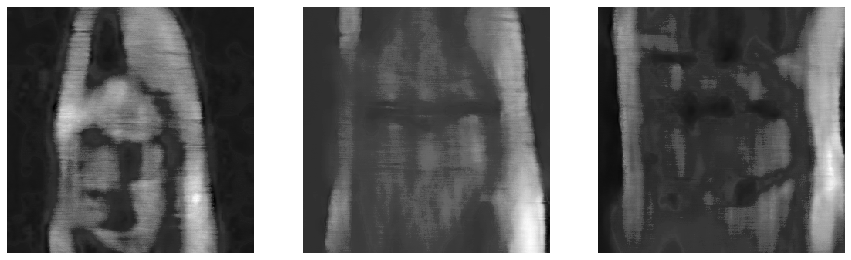

/tmp/nc-32/file1000818.h5


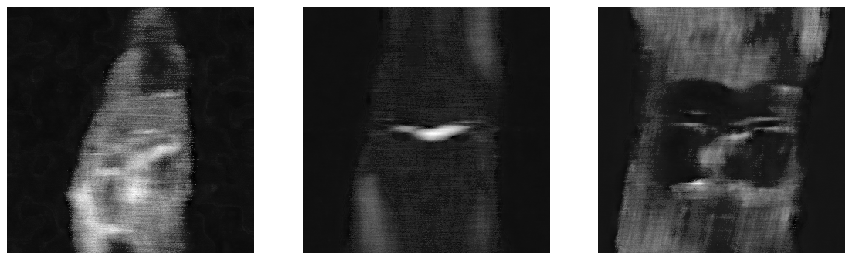

/tmp/nc-32/file1000831.h5


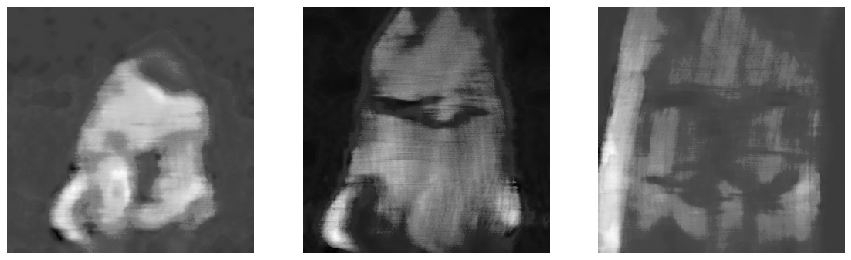

/tmp/nc-32/file1000842.h5


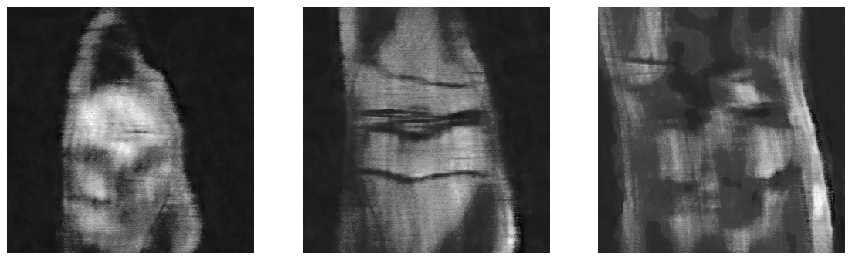

/tmp/nc-32/file1000858.h5


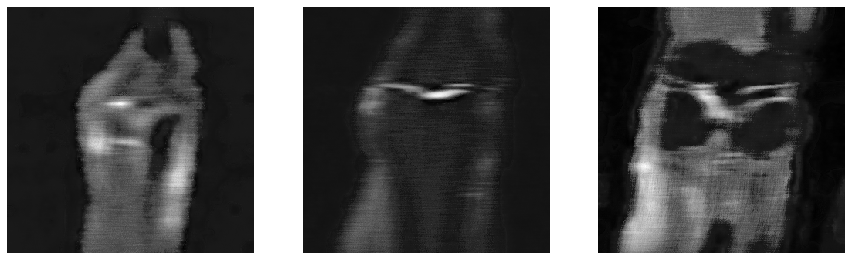

/tmp/nc-32/file1000871.h5


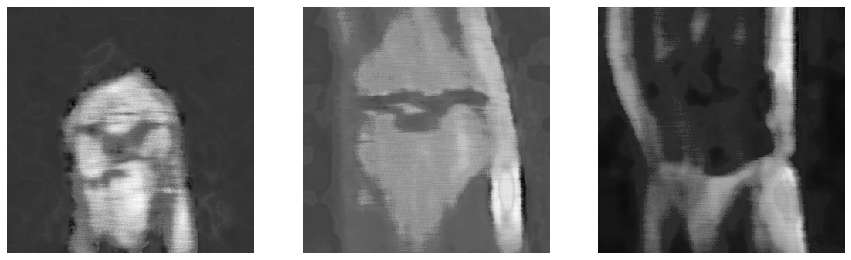

/tmp/nc-32/file1000885.h5


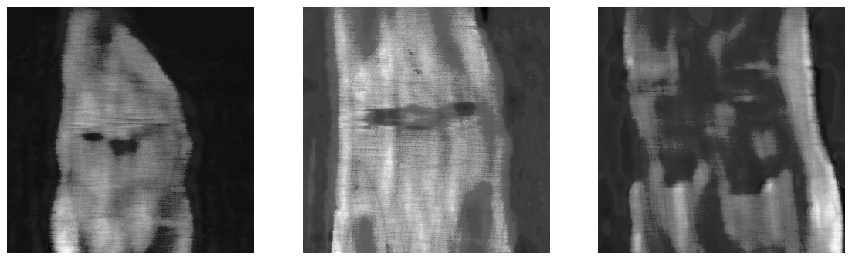

/tmp/nc-32/file1000891.h5


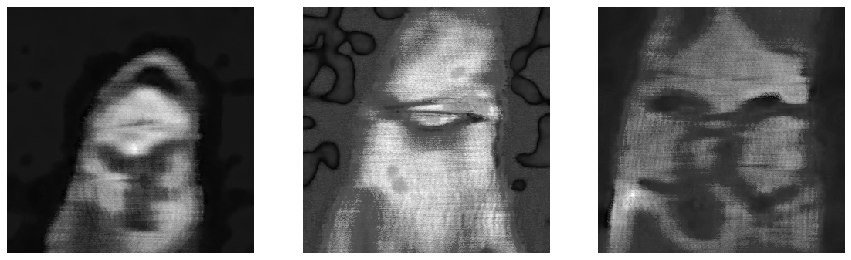

/tmp/nc-32/file1000899.h5


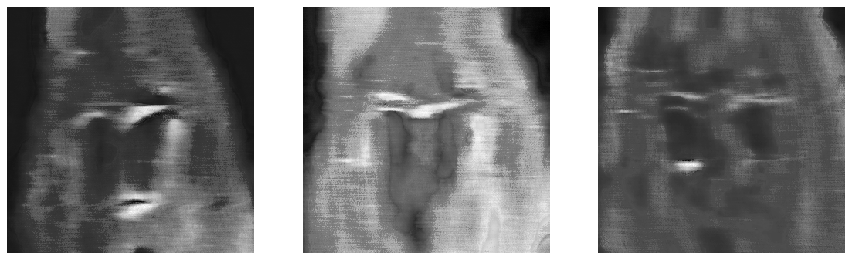

/tmp/nc-32/file1000903.h5


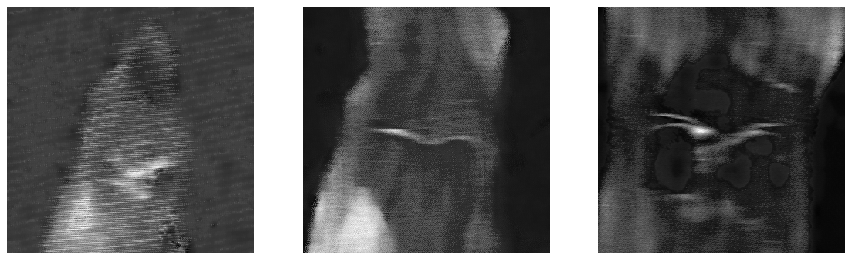

/tmp/nc-32/file1000925.h5


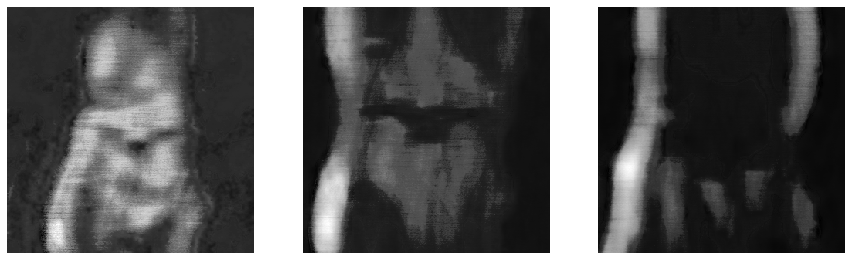

/tmp/nc-32/file1000926.h5


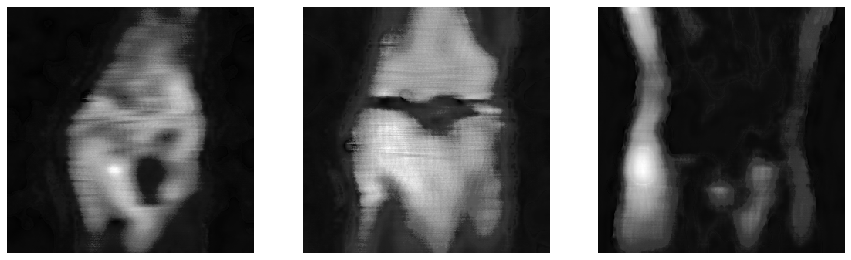

/tmp/nc-32/file1000932.h5


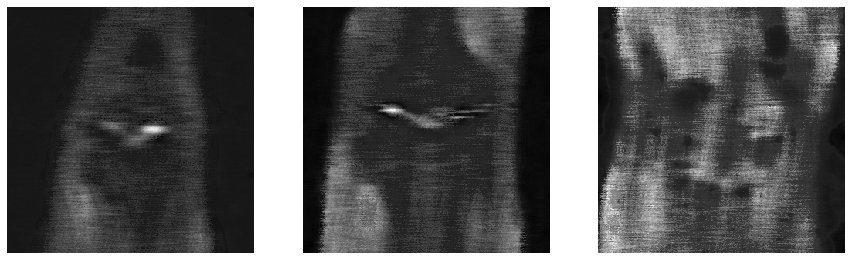

/tmp/nc-32/file1000942.h5


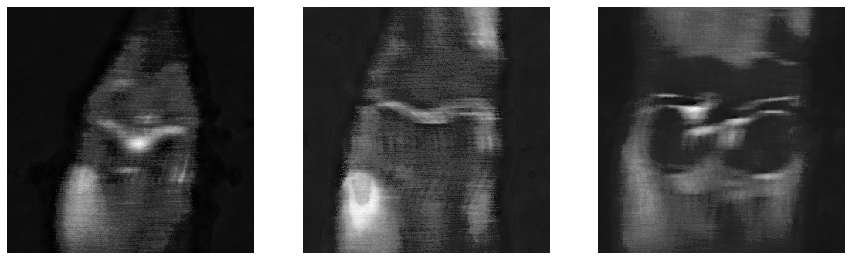

/tmp/nc-32/file1000972.h5


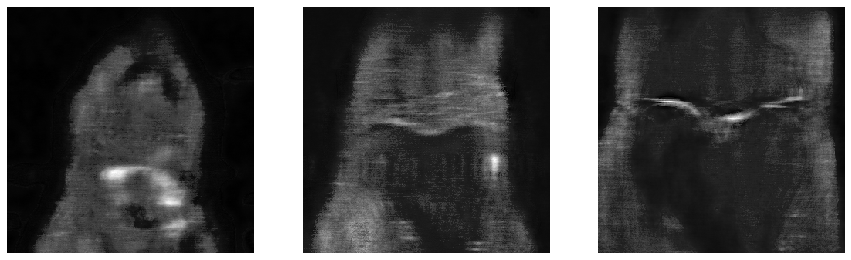

/tmp/nc-32/file1000976.h5


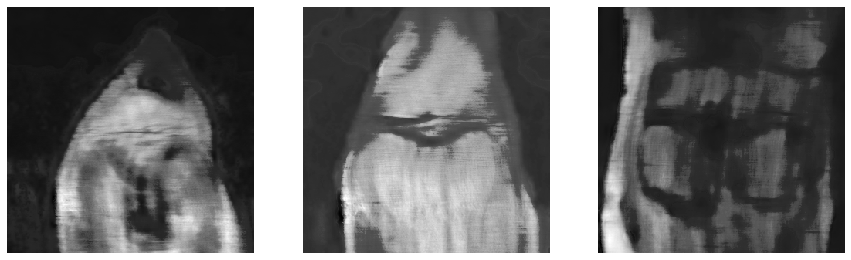

/tmp/nc-32/file1000990.h5


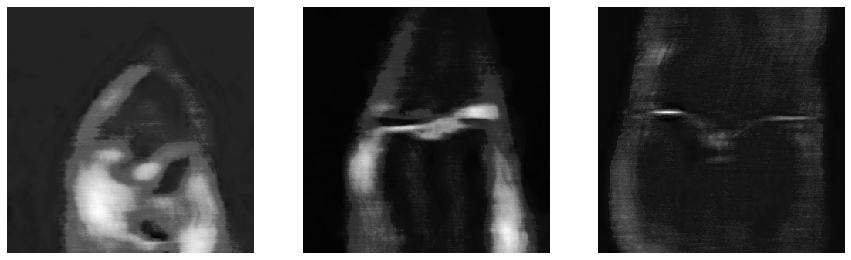

/tmp/nc-32/file1001031.h5


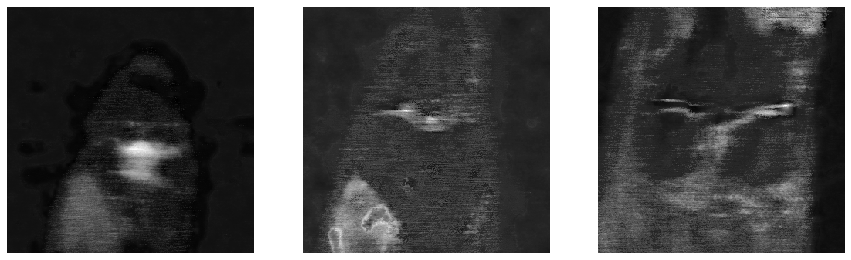

/tmp/nc-32/file1001057.h5


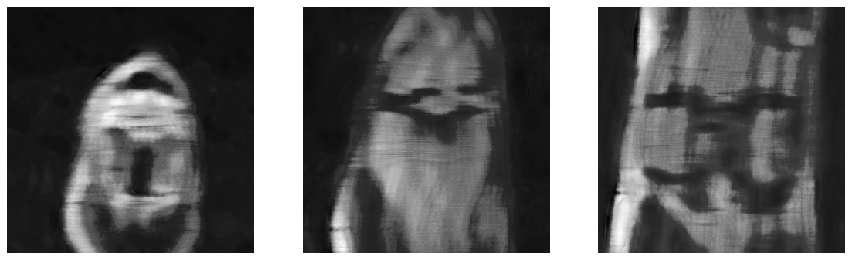

/tmp/nc-32/file1001059.h5


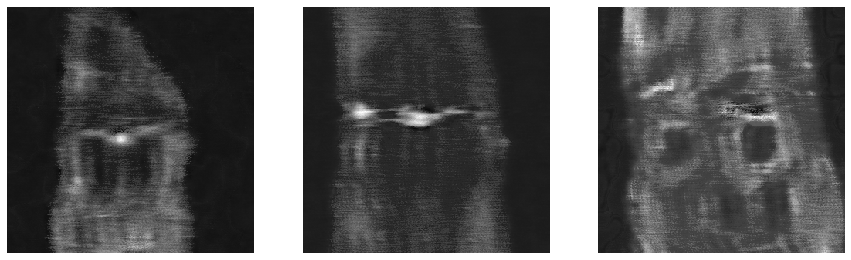

/tmp/nc-32/file1001064.h5


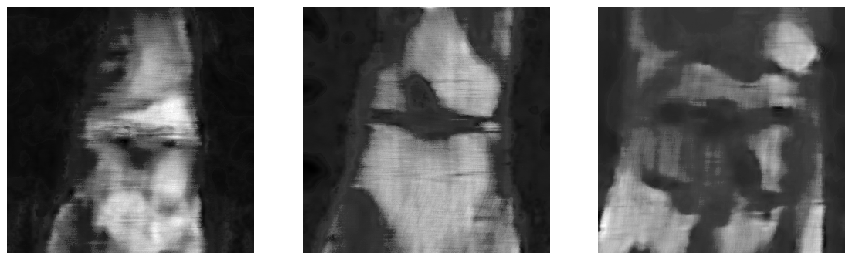

/tmp/nc-32/file1001077.h5


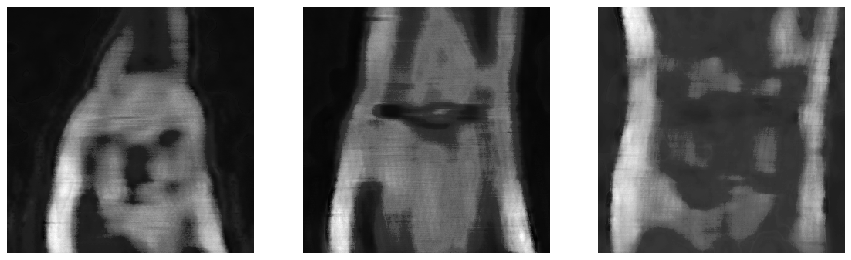

/tmp/nc-32/file1001090.h5


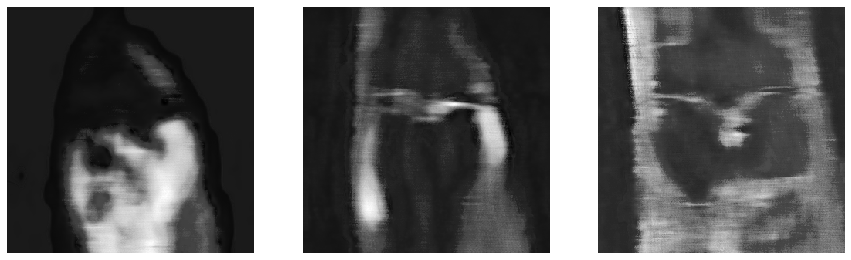

/tmp/nc-32/file1001096.h5


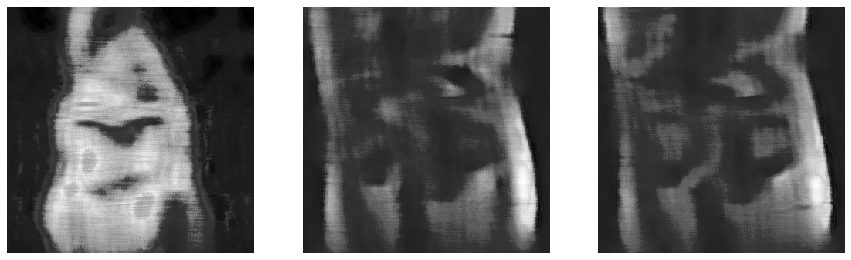

/tmp/nc-32/file1001104.h5


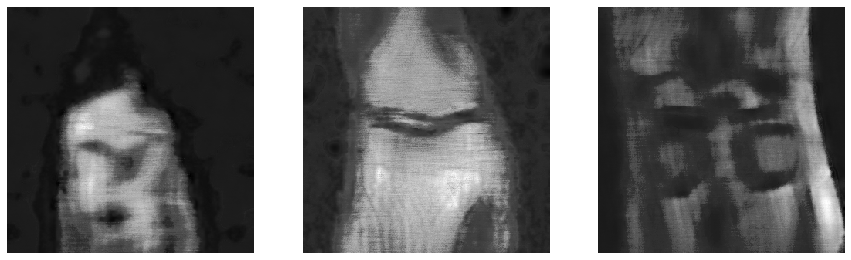

/tmp/nc-32/file1001119.h5


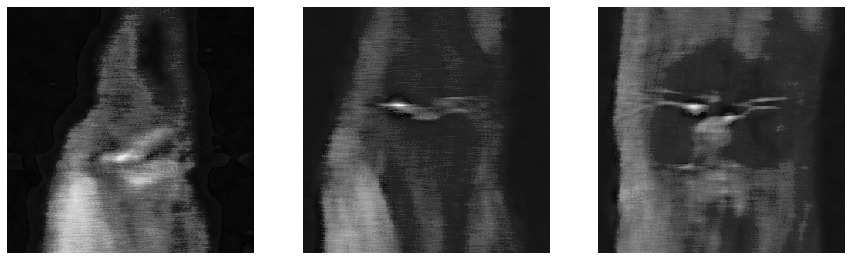

/tmp/nc-32/file1001122.h5


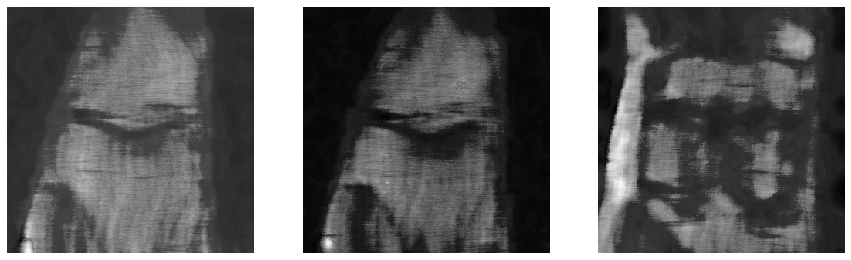

/tmp/nc-32/file1001126.h5


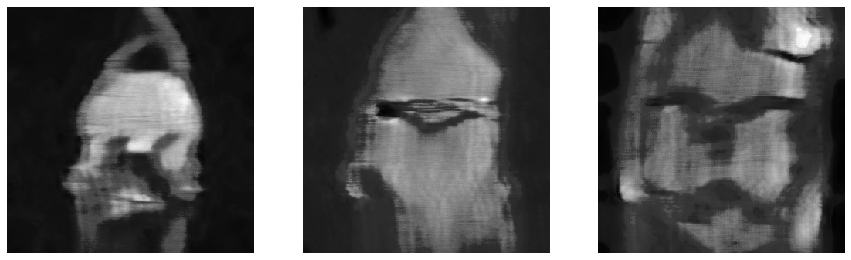

/tmp/nc-32/file1001140.h5


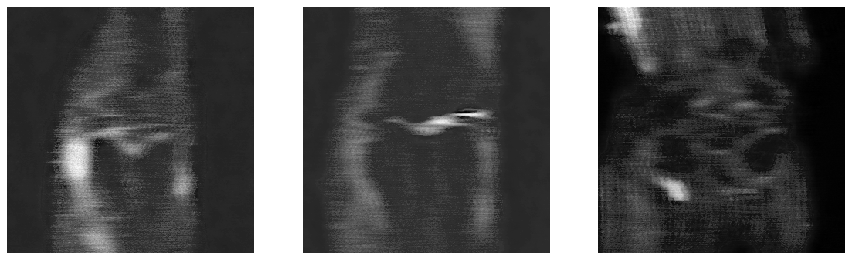

/tmp/nc-32/file1001143.h5


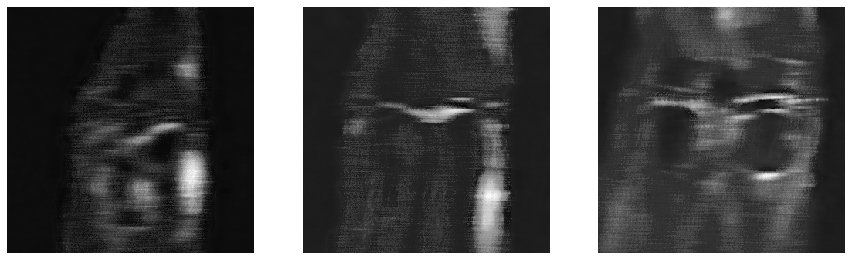

In [24]:
imgs = []

for fname in sorted(os.listdir(out_dir)):
    test_path = os.path.join(out_dir, fname)
    
    with h5py.File(test_path,  "r") as hf:
        print(test_path)
        data = hf[key][()]
        show_slices(data, [5, 10, 20], cmap='gray')
        plt.pause(1)

## Experiments

As discussed in the Design section, the outcomes for out neural network experimentations have been outlined below. An overall conclusion for the experiments has been included at the bottom of this section. 

### Epochs
|10|20|30|
|---|---|---|
|![](loss-8f-10.png)|![](loss-4f-20e.png)|![](loss-4f-30.png)|

|50|80|
|---|---|
![](loss-4f-50.png)|![](loss-4f-808norm-rmsprop.png)|

Fig 2. Epoch Training and Loss Graphs

The first hyperparameter to experiment with was the number of epochs the model runs for. 

In many cases, higher epoch numbers did not correlate with better results: often models were training for longer and were not improving significantly. This is because most models reached their peak performance quite early on (15-20 epochs), especially since we were using RMSprop as our testing optimizer. With lower epoch values the model would simply not learn enough of the feature space resulting in poor performance. Our epochs averaged at 45s-1m each, resulting in models with epoch numbers over 60 taking over an hour to train.  The models we left running for over 40 epochs often did not improve enough to justify this extra time.

After testing, we settled for an optimal value of 30. As epoch values increased, the quality of our results did not reflect this extra training time. For this reason, we chose to compromise with an epoch value that was low enough to produce good results, whilst allowing us to carry out a higher number of tests quickly.    


### Step-Size

| Epochs  | Learning Rate | Dropout Probability  | Step-Size | Training Loss  | Validation Loss | SSIM_preds |
|---|---|---|---|---|---|---|
|10      |0.001      |0.01      |10      |0.05328      |0.05013      |0.3800|
|10      |0.001      |0.01      |11      |0.05424      |0.05082      |0.4465|
|10      |0.001      |0.01      |12      |0.05476      |0.04890      |0.4260|
|10      |0.001      |0.01      |15      |0.05296      |0.05017      |0.4207|
|10      |0.001      |0.01      |16      |0.05325      |0.05091      |0.3800|
|30      |0.001      |0.01      |10      |0.05269      |0.04789      |0.3706|
|30      |0.001      |0.01      |11      |0.05013      |0.04668      |0.4179|
|30      |0.001      |0.01      |12      |0.05061      |0.04780      |0.4666|
|30      |0.001      |0.01      |13      |0.04993      |0.04622      |0.3830|
|30      |0.001      |0.01      |15      |0.05024      |0.04783      |0.4344|
|30      |0.001      |0.01      |30      |0.05027      |0.04895      |0.3967|


Fig 3. Table of step-size values and their respective performance measure

We firstly experiment the models with some default values of learning rate and dropout probability is 0.001 and 0.01 respectively, but keep epochs at a relatively low level of 10 where can save time of running to get a ballpark direction of how is this hyperparameter generally influence the model. 
<br>
From a series of learning we noticed that the step size works an improving result with the range from 11-15, where there is a dramatic drop in the gap between 10 to 11 and the gap between 15 to 16. 
<br>
Interestingly, we found that the value of SSIM outcomes appear to be the same when set the step size to 10 and 16, and the closer the step size is to 11 the better result there is, regardless of how big the value is. 
<br>
But things changed when we tried to alter epochs to 30 which is the ideal hyperparameter we carried out above. In this case, Step_Size = 11 no longer perform the best result but step_size = 12 took over the position of best step size. 
<br>
In summary, we find in our model, the most optimised value of SSIM outcome will appear when step_size = 12 with epochs = 30 (default learning rate = 0.001, dropout probability = 0.01). This also suggest learning rate adjustment after certain epoch should be carried out to improve the performance in learning. 


### Dropout Probability
| Epochs  | Learning Rate | Dropout Probability  | Step Size | decay | Training Loss  | Validation Loss | SSIM_preds |
|---|---|---|---|---|---|---|---|
|30|0.001|0.1|15|0|0.06282|0.06261|0.4318|
|30|0.001|0.05|15|0|0.5876|0.05560|0.4156|
|30|0.001|0.01|15|0|0.05181|0.04820|0.4497|
|30|0.001|0.001|15|0|0.04739|0.04509|0.3900|
|30|0.001|0.0001|15|0|0.04536|0.04433|0.1495|
|30|0.1|0.005|11|0|0.05333|0.05069|0.3938|
|30|0.1|0.01|11|0|0.05809|0.05281|0.4180|
|15|0.1|0.005|11|0|0.05850|0.05532|0.4345|
|15|0.1|0.01|11|0|0.05224|0.04905|0.4144|
|30|0.1|0.1|15|0|0.07274|0.07608|0.4462|
|30|0.1|0.5|15|0|inf|inf|nan|
|30|0.1|0.001|15|0|0.05590|0.05359|0.3425|
|30|0.1|0.005|15|0|0.05826|0.05643|0.3800|


Fig 4. Table of dropout probability values and their respective performance measure

While experimenting with dropout probability, I noticed that a value of 0.5 caused an infinite loss function. This made it impossible to take an SSIM reading. The lowest SSIM value, 0.149506, was achieved using a dropout probability of 0.0001. All other SSIM values for this experiment fell within the range 0.34 to 0.45. As the lowest dropout probability we trialled that remained within this range, all values below 0.001 were considered to be non-viable. 

The highest SSIM result in this part of experimentation, 0.44972, was achieved using a dropout probability of 0.01. Both training and validation loss were also reasonably low at this value relative to the other readings in this section. As a result, it was concluded that 0.01 was optimal for this parameter. 


### Learning Rate 
| Epochs  | Learning Rate | Dropout Probability  | Step Size | decay | Training Loss  | Validation Loss | SSIM_preds |
|---|---|---|---|---|---|---|---|
|30|0.005|0.01|15|0|0.05300|0.05024|0.4190|
|30|0.0001|0.01|15|0|0.05370|0.05040|0.3571|
|30|0.05|0.01|15|0|0.05610 |0.05411|0.3943|

Fig 5. Table of learning rate values and their respective performance measure

By having a learning rate of 0.005 it reaches the highest SSIM, and it also reaches the minimum loss for both Training and Validation.

### Learning Rate Gamma (Change in Learning Rate) Learn
| Epochs  | Learning Rate | Dropout Probability  | Step Size | gamma | Training Loss  | Validation Loss | SSIM_preds |
|---|---|---|---|---|---|---|---|
|30|0.1|0.1|15|0.01|0.07274|0.07608|0.4462|
|30|0.1|0.1|15|0.5|0.09146|0.08963|0.2128|
|30|0.1|0.1|15|0.1|0.09146|0.08963|-0.2370|
|30|0.1|0.1|15|0.001|0.07820|0.07600|0.4264|
|30|0.1|0.1|15|0.005|0.07580|0.07641|0.4178|
|30|0.1|0.1|15|0.05|0.07529|0.07066|0.4405|

Fig 6. Table of learning rate gamma values and their respective performance measure

By having a change in Learning rate at 0.01 is the most optimal value which reaches 0.44 SSIM as well as 0.07 Loss in Training and Validation which is the minimum among the other values. 


### Channels

For all channel tests, we kept the values of all other parameters consistent. The values chosen were based on the best results found in the step_size experiments above. 


    epochs = 30
    dropout_prob = 0.01
    learning_rate = 0.001
    weight_decay = 0.01
    step_size = 11
    lr_gamma = 0.1
    num_pool_layers = 4
    optimizer=RMSprop
    loss function = L1

|Fold number|Channels|Training Loss|Validation Loss|SSIM Accuracy|
|---|---|---|---|---|
|4|8|0.05295|0.04921|0.4143|
|4|16|0.04998|0.04649|0.3717|
|4|32|0.05240|0.04922|0.3723|
|4|64|0.05039|0.048842|0.4031|
|4|128|0.04652|0.04264|0.4088|
|8|8|0.0720|0.07030|0.3309|
|8|16|0.06899|0.06834|0.3229|
|8|32|0.06578|0.06576|0.3213|
|8|64|0.06497|0.06791|0.3086|
|8|128|0.06577|0.0636|0.3058|


Fig 7. Table of channels and their respective performance measures

When trying to run with 256 channels, Cuda ran out of memory and so no values can be shown. 

Interestingly, for both folds, 8 is the best channel for the given parameters, however, the reason for this can quickly be deduced, as discussed below. 

|8|16|128|
|---|---|---|
|![](loss-4f-308rmsprop.png)|![](loss-4f-3016-rmsprop.png)|![](loss-4f-30128-rmsprop.png)|

Fig 8. Table of 4f channels train/val los graphs

Unfortunately, only graphs for 8, 16 and 128 epochs were recoverable for 4f, as the files were corrupted. 

The graph for 8 channels shows that by 15 epochs it reached almost optimal performance, with epochs up to 30 continuing to gradually decrease loss. On the other hand,  this optimal mark is never reached in the graphs for 16 and 128 channels. The reason for this is that a larger feature space is trying to be learnt, and the model is not being given enough time to learn this space well. A solution to this would be to leave higher channels running for a larger number of epochs, however, for cases like 128 channels, this results in a significantly higher run time and computational power that could not be handled by the hardware (for reference, running with 128 channels and 30 epochs used 96% of GPU power). 

Interestingly, the values for 64 and 128 channels are closer to the value given by 8 channels than 16 and 32. This is an interesting result, and despite carrying out some research we are unable to obtain any explanations.


|8|16|32|
|---|---|---|
|![](loss-8f-channel-8.png)|![](loss-8f-3016rms.png)|![](loss-8f-3032rms.png)|
|64|128|
|![](loss-8f-3064rms.png)|![](loss-8f-channel-128.png)|

Fig 9. Table of 8f channels train/val loss graphs

The low performance of higher channels for 8f can be explained with the same reasoning as that of 4f above. 


### Loss Functions 

All loss functions were tested with the following hyperparameters:

    epochs = 105
    dropout_prob = 0.01
    learning_rate = 0.1
    weight_decay = 0.0
    step_size = 15
    lr_gamma = 0.1
    num_pool_layers = 4
    chans = 8 

L1 Loss: This was the first loss function we used as it was the simplest to implement. It isn’t the best but allowed for the rest of the network to be built and tested while other loss functions were considered. It produced a training loss of 0.06534 and a validation loss of 0.06145 with an SSIM of 0.41429 at 4 fold acceleration.
![](l1loss-4f-105e-0.1learn.png)
Fig 10. Graph of loss against the number of epochs for the L1 loss function

L2 Loss: This loss function performed considerably better than the L1 function as can be seen in figure 10. It reduced training and validation loss to 0.006370 and 0.005810 and produced an SSIM of 0.41877 at 4 fold acceleration. Due to how this function handles large errors large spikes can be seen in figure 11 but they level off and leave a lower loss.
![](l2loss-4f-105e-01learn.png)
Fig 11. Graph of loss against the number of epochs for the L2 loss function

SSIM Loss: Theoretically this would be a good function to use as it focuses on maximising SSIM, however, our implementation resulted in a SSIM of 0.09848 and the reconstruction this made can be seen in figure 12.
![](ssimlossoutput.png)
Fig 12. The centre image is the ground truth, left is the ground truth undersampled and right is our reconstruction.

### Optimizers

To ensure all optimizer were tested equally, a consistent setting was used for all other hyperparameters, as shown below. The values were chosen at random, and are not drawn from the results of hyperparameter testing. 

    epochs = 30
    dropout_prob = 0.01
    learning_rate = 0.1
    weight_decay = 0.0
    step_size = 15
    lr_gamma = 0.1
    num_pool_layers = 4
    chans = 8             # num of channels
    loss function = L1

The table below lists all the SSIM measures and final training/validation loss for each optimizer for both of the undersampling rates. The results for 4f and 8f are quite consistent with one another, and are explored further through graphs below.


|Fold number|Optimizer|Training Loss|Validation Loss|SSIM Accuracy|
|---|---|---|---|---|
|4|Adagrad|0.051821|0.048778|0.41008|
|4|Adam|0.049791|0.049859|0.37895
|4|ASGD (Averaged Stochastic Gradient Descent)|0.052209|0.050458|0.40193|
|4|RMSprop|0.067036|0.064925|0.42793|
|4|SGD (Stochastic Gradient Descent)|0.069914|0.069806|0.31157|
|8|Adagrad|0.073590|0.074585|0.32659|
|8|Adam|0.074420|0.077764|0.39571|
|8|ASGD (Averaged Stochastic Gradient Descent)|0.073846|0.074285|0.37586|
|8|RMSprop|0.078464|0.081506|0.38945|
|8|SGD (Stochastic Gradient Descent)|0.076306|0.071779|0.38620|

Fig 13. Table of optimizers and their respective performance measures

![](train-loss-4f-optimizers.png)

Fig 14. Graph of each optimizers training loss against the number of epochs
![](val-loss-4f-optimizers.png)

Fig 15. Graph of each optimizers validation loss against the number of epochs

|Adagrad|Adam|ASGD|
|---|---|---|
|![](loss-4f-30adagrad.png)|![](loss-4f-30adam.png)|![](loss-4f-30asgd.png)|
|RMSprop|SGD|
|![](loss-4f-30rmsprop.png)|![](loss-4f-30sgd.png)|

Fig 16. Table of l1 loss graphs for all optimizers for 4 fold undersampling.

Despite RMSprop giving the best results after 30 epochs for 4, it could be argued other optimizers, such as Adam, would perform better with a higher number of epochs. 
This is because, from the graphs displayed below, it appears that RMSProp hits its peak at around 25 epochs, whereas Adam is still gradually decreasing. 

![](optimizercom8f.png)
Fig 17. Graph of SSIM accuracy against optimizer

|Adagrad|Adam|ASGD|
|---|---|---|
|![](loss-8f-30adagrad.png)|![](loss-8f-30adam.png)|![](loss-8f-30asgd.png)|
|RMSprop|SGD|
|![](loss-8f-30rmsprop.png)|![](loss-8f-30sgd.png)|

Fig 18. Table of L1 loss graphs for all optimizers for 4 fold undersampling.

Similarly, RMSProp gives the best results for 8 fold after 30 epochs. Instead of showing a combined loss graph, we have included a graph of relative SSIM scores for each optimizer after the training epochs, for ease of comparison. This allows us to see that Stochastic Gradient Descent performs on par with RMSprop for this setting, and the overall loss graphs suggest it may outperform both RMSprop and Adam for larger epoch values.


### Pooling Layers

Due to computation constraints, large pooling layers could not be experimented with, even when decreasing other factors that such as learning_rate. For this reason we have only derived results for 4 and 8 layers. 

By increasing the number of pooling layers from 4 to 8, we added another set of Conv2d, InstanceNorm2d, ReLU and Dropout2d layers into each of the convolutional blocks described in the implementation section of this report.

![](8_pool_layers.png)
Fig 19. Performance metric comparison for 8 pooling layers for Adam and RMSprop optimizers


The overall performance, while using Adam as SSIM for 4f was similar to the performance of a network with 4 pooling layers, as noticeable from the SSIM output of 0.39177. However, the loss graph allows us to observe that the optimal loss had not yet been reached in the space of 30 epochs. 
For this reason, we re-ran the model twice more with 80 epochs. For comparison, we also ran this using RMSprop as an optimizer. While the training and validation losses for both optimizers at this pooling layer value were very similar (within 0.002), Adam’s SSIM score outshone RMSprop by 6% (0.40658 compared to 0.34646).


Figures for reference: <br>
Adam: TrainLoss: 0.05297, ValLoss 0.049658, SSIM: 0.4066 <br>
RMSprop: TrainLoss: 0.05048, ValLoss 0.04961, SSIM: 0.3465


## Conclusion of Experiments
As a results of our experiments, we deduced that the best settings for our network were as follows:

    epochs = 30
    dropout_prob = 0.01
    learning_rate = 0.001
    weight_decay = 0.0
    step_size = 15
    lr_gamma = 0.1
    num_pool_layers = 4
    optimizer=RMSprop
    loss function = L2

The results from running a model with these settings were far from optimal, with the SSIM accuracy score averaging at 35%. 

The reason for this could stem from the fact our tests were all using random parameters, rather than ones we had already discovered to be good. In order to do this, we would have had to run experiment groups in series rather than in parallel. Ultimately we did not have enough time to do this. 

For this reason, for our final submission, we opted to choose the set of values in experimentation that gave us the highest SSIM.

[Values Reference - Fig3]

    epochs = 30
    dropout_prob = 0.01
    learning_rate = 0.001
    weight_decay = 0.0
    step_size = 12
    lr_gamma = 0.1
    num_pool_layers = 4
    optimizer=RMSprop
    loss function = L1



## Conclusion

The goal of this task was to reconstruct adequately detailed images from undersampled MRI scans. Whilst our model was able to reconstruct the images they were not close enough to the ground truth to be a viable alternative to un-altered MRI scans. The average SSIM for our model with what we believe to be optimal parameters was 0.43126 for 4f acceleration and 0.36912 for 8f.

The factors we found to be most crucial in determining the output of our model were step size and learning rate, as changing them, whilst at a fixed epoch number, had the greatest impact on our models performance.

To improve on the model in the future there are a few simple changes that could be made: an adaptive learning rate could be implemented and the Adam optimiser could be used at a higher number of epochs. In addition to this, we would consider extending the basic U-Net used to different architectures such as FusionNet or U-Net++.


## Description of Contribution

|Name             | ID | Contribution |
|-----------------|---|--------------|
|Jay Upadhyay | 1782049 |Research on different types of neural networks and CNN architectures. Implementation and experimentation of loss functions.|
|Bhavina Mistry | 1658399|Research of CRNN’s, implementation of U-Net, and experimentation on epochs, channels, optimizers and pooling layers|
|ChiHo Kwan | 1859303|Research on FusionNet, carry out experiment on Dropout_probability, learning rate, lr_gamma |
|Peter Wang | 1824261|Research on neural networks and masks, practicing the different hyperparameters to optimize the best result.|
|Jonathan Crowe | 1572557|Researched NN models and attempted an implementation (Bhavina quickly developed an effective program and we have ultimately only used her's). Experimentation with hyperparameters in order to identify optimal values.|

## Reference List

1.  Authors: Jure Zbontar , Florian Knoll , Anuroop Sriram and Others <br>
    Title: fastMRI: An Open Dataset and Benchmarks for Accelerated MRI <br>
    URL: https://arxiv.org/pdf/1811.08839.pdf <br>
2.  Authors: Muhammad Imran Razzak, Saeeda Naz and Ahmad Zaib <br>
    Title: Deep Learning for Medical Image Processing: Overview, Challenges and Future <br>
    URL: https://arxiv.org/ftp/arxiv/papers/1704/1704.06825.pdf2.  <br>
3.  Authors: FaceBook Research <br>
    Title: “U-Net Model for MRI Reconstruction” <br>
    URL: https://github.com/facebookresearch/fastMRI/tree/master/models/unet <br>
4.  Authors: Mattson Thieme and Tony Reina <br>
    Title: “Biomedical Image Segmentation With U-Net - Upsampling Versus Transposed Convolution” <br>
    URL: https://www.intel.ai/biomedical-image-segmentation-u-net/#gs.l7ples <br>
5.  Authors: Gao Huang, Zhuang Liu, Killian Q. Weinberger and Lauren van der Maaten <br>
    Title: “Densely Connected Convolutional Networks” <br>
    URL: https://arxiv.org/pdf/1608.06993v3.pdf <br>
6.  Authors: Chen Qin , Jo Schlemper, Jose Caballero, Anthony N. Price, Joseph V. Hajnal and Daniel Rueckert Fellow <br>
    Title “Dynamic MR Image Reconstruction” <br>
    URL: https://arxiv.org/pdf/1712.01751.pdf <br>
7.  Authors: Tran Minh Quan, David G. C. Hildebrand and Won-Ki Jeong  <br>
    Title: “FusionNet: A deep fully residual convolutional neural network for image segmentation in connectomics” <br>
    URL: https://arxiv.org/pdf/1612.05360.pdf <br>
8.  Authors: Tran Minh Quan, Thanh Nguyen-Duc, and Won-Ki Jeong, <br>
    Title: "Compressed Sensing MRI Reconstruction using aGenerative Adversarial Network with a Cyclic Loss" <br>
    URL: https://www.profillic.com/paper/arxiv:1709.00753#title <br>